In [ ]:
# Calling convert_taco_to_yolo.py, to create train/val/test folders, and fill out data/recycle.yaml

In [150]:
from pathlib import Path
from collections import Counter
import os, subprocess, sys, json, random, shutil
import pandas as pd

In [120]:
# Detect repo root (works whether you start in repo/ or repo/notebooks/)
CWD = Path().resolve()
if (CWD / ".git").exists() and (CWD / "data").exists():
    REPO_ROOT = CWD
elif (CWD.parent / ".git").exists() and (CWD.parent / "data").exists():
    REPO_ROOT = CWD.parent
else:
    raise SystemExit("❌ Could not find repo root. Open the notebook from the repo or repo/notebooks.")

In [121]:
print("Repo root:", REPO_ROOT)

Repo root: C:\Users\lisan\Jupyter Notebook Projects\Recycling-YOLO


In [128]:
RAW_DIR       = REPO_ROOT / "data" / "raw" / "taco"
COCO_JSON     = RAW_DIR / "annotations.json"
IMAGES_DIR    = RAW_DIR / "images"
CLASS_MAP     = REPO_ROOT / "data" / "scripts" / "class_map.json"
CONVERTER     = REPO_ROOT / "data" / "scripts" / "convert_taco_to_yolo.py"
PROC_IMG_ALL  = REPO_ROOT / "data" / "processed" / "images" / "all"
PROC_LBL_ALL  = REPO_ROOT / "data" / "processed" / "labels" / "all"
NAMES_TXT     = REPO_ROOT / "data" / "processed" / "names.txt"
RECYCLE_YAML  = REPO_ROOT / "data" / "recycle.yaml"

for p in [COCO_JSON, IMAGES_DIR, CLASS_MAP, CONVERTER, NAMES_TXT]:
    print(("✅" if p.exists() else "❌"), p)

✅ C:\Users\lisan\Jupyter Notebook Projects\Recycling-YOLO\data\raw\taco\annotations.json
✅ C:\Users\lisan\Jupyter Notebook Projects\Recycling-YOLO\data\raw\taco\images
✅ C:\Users\lisan\Jupyter Notebook Projects\Recycling-YOLO\data\scripts\class_map.json
✅ C:\Users\lisan\Jupyter Notebook Projects\Recycling-YOLO\data\scripts\convert_taco_to_yolo.py
❌ C:\Users\lisan\Jupyter Notebook Projects\Recycling-YOLO\data\processed\names.txt


In [129]:
# running convert coco to yolo
import subprocess, sys

args = [
    sys.executable, "-u",
    str(REPO_ROOT / "data" / "scripts" / "convert_taco_to_yolo.py"),
    "--coco", "data/raw/taco/annotations.json",      # relative is fine now
    "--images", "data/raw/taco/images",
    "--class_map", "data/scripts/class_map.json",
    "--out_images", "data/processed/images/all",
    "--out_labels", "data/processed/labels/all",
    "--names_out", "data/processed/names.txt",
]
print("Running:\n", " ".join(f'"{a}"' if " " in a else a for a in args))
p = subprocess.Popen(args, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, bufsize=1, cwd=str(REPO_ROOT))
for line in p.stdout:
    print(line, end="")
p.wait()

print("names.txt exists?", NAMES_TXT.exists())
if NAMES_TXT.exists():
    print(NAMES_TXT.read_text())
    

Running:
 C:\Users\lisan\anaconda3\python.exe -u "C:\Users\lisan\Jupyter Notebook Projects\Recycling-YOLO\data\scripts\convert_taco_to_yolo.py" --coco data/raw/taco/annotations.json --images data/raw/taco/images --class_map data/scripts/class_map.json --out_images data/processed/images/all --out_labels data/processed/labels/all --names_out data/processed/names.txt
 Resolved paths:
  COCO       : data\raw\taco\annotations.json
  IMAGES     : data\raw\taco\images
  CLASS_MAP  : data\scripts\class_map.json
  OUT_IMAGES : C:\Users\lisan\Jupyter Notebook Projects\Recycling-YOLO\data\processed\images\all
  OUT_LABELS : C:\Users\lisan\Jupyter Notebook Projects\Recycling-YOLO\data\processed\labels\all
  NAMES_OUT  : C:\Users\lisan\Jupyter Notebook Projects\Recycling-YOLO\data\processed\names.txt
 Converted images: 458
 Converted annotations: 702
 Size-mismatch images (auto-rescaled): 0
 Skipped tiny boxes (< 4.0px): 0
 Missing image files: 0
 Class order saved to: C:\Users\lisan\Jupyter Notebo

In [130]:
# create splits
random.seed(123)

IMG_EXTS = {".jpg", ".jpeg", ".png"}
PROC_IMG_ALL = REPO_ROOT / "data" / "processed" / "images" / "all"
PROC_LBL_ALL = REPO_ROOT / "data" / "processed" / "labels" / "all"

all_imgs = sorted([p for p in PROC_IMG_ALL.rglob("*") if p.suffix.lower() in IMG_EXTS])

def lbl_for(img_path: Path) -> Path:
    rel = img_path.relative_to(PROC_IMG_ALL)                  # keep subdirs
    return PROC_LBL_ALL / rel.with_suffix(".txt")

paired = [(im, lbl_for(im)) for im in all_imgs if lbl_for(im).exists()]
print(f"Total converted pairs: {len(paired)}")

random.shuffle(paired)
n = len(paired)
n_train = int(0.8 * n); n_val = int(0.1 * n)

splits = {
    "train": paired[:n_train],
    "val":   paired[n_train:n_train+n_val],
    "test":  paired[n_train+n_val:],
}
for split, items in splits.items():
    print(split, len(items))

# write split folders (still flat is okay since pairs are correct here)
for split, items in splits.items():
    out_i = REPO_ROOT / "data" / "processed" / "images" / split
    out_l = REPO_ROOT / "data" / "processed" / "labels" / split
    if out_i.exists(): shutil.rmtree(out_i)
    if out_l.exists(): shutil.rmtree(out_l)
    out_i.mkdir(parents=True, exist_ok=True)
    out_l.mkdir(parents=True, exist_ok=True)

    for im, lb in items:
        shutil.copy2(im, out_i / im.name)
        shutil.copy2(lb, out_l / lb.name)


Total converted pairs: 458
train 366
val 45
test 47


In [131]:
import yaml

names = [line.strip() for line in NAMES_TXT.read_text().splitlines() if line.strip()]
yaml_obj = {
    "train": "data/processed/images/train",
    "val":   "data/processed/images/val",
    "test":  "data/processed/images/test",
    "nc": len(names),
    "names": names,
}
with open(RECYCLE_YAML, "w") as f:
    yaml.safe_dump(yaml_obj, f, sort_keys=False)

print("Wrote", RECYCLE_YAML)
print(Path(RECYCLE_YAML).read_text())


Wrote C:\Users\lisan\Jupyter Notebook Projects\Recycling-YOLO\data\recycle.yaml
train: data/processed/images/train
val: data/processed/images/val
test: data/processed/images/test
nc: 3
names:
- plastic_bottle
- glass_bottle
- metal_can



In [132]:
def count_pairs(split):
    base_i = REPO_ROOT / "data" / "processed" / "images" / split
    base_l = REPO_ROOT / "data" / "processed" / "labels" / split
    imgs = sorted([p for p in base_i.glob("*") if p.suffix.lower() in IMG_EXTS])
    labels = [base_l / (im.with_suffix(".txt").name) for im in imgs]
    missing = [str(im.name) for im, lb in zip(imgs, labels) if not lb.exists()]
    return len(imgs), len(missing), missing[:5]

for s in ["train", "val", "test"]:
    n_imgs, n_miss, miss_sample = count_pairs(s)
    print(f"{s}: images={n_imgs}, missing_labels={n_miss}, sample={miss_sample}")

df = pd.DataFrame({
    "split": ["train","val","test"],
    "images": [count_pairs(s)[0] for s in ["train","val","test"]]
})
df


train: images=138, missing_labels=0, sample=[]
val: images=40, missing_labels=0, sample=[]
test: images=40, missing_labels=0, sample=[]


,split,images
0,train,138
1,val,40
2,test,40


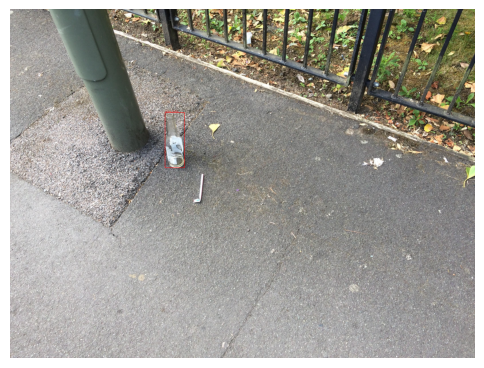

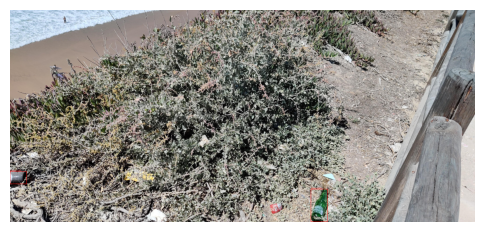

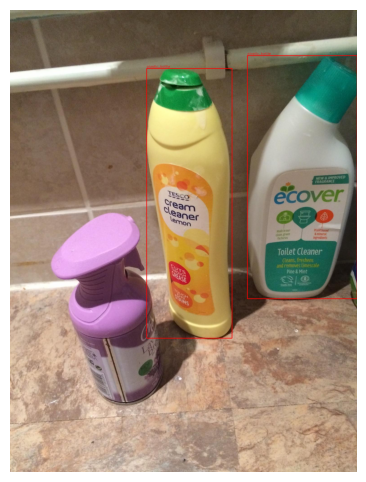

In [133]:
#vizualize checks
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

train_i = REPO_ROOT / "data" / "processed" / "images" / "train"
train_l = REPO_ROOT / "data" / "processed" / "labels" / "train"
names   = [l.strip() for l in NAMES_TXT.read_text().splitlines() if l.strip()]

samples = random.sample([p for p in train_i.glob("*") if p.suffix.lower() in IMG_EXTS], k=min(3, len(list(train_i.glob('*')))))

def draw_yolo(img_path: Path):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    lbl_path = train_l / (img_path.with_suffix(".txt").name)
    if lbl_path.exists():
        for line in lbl_path.read_text().splitlines():
            if not line.strip(): continue
            cls, xc, yc, bw, bh = line.split()
            cls = int(cls); xc=float(xc); yc=float(yc); bw=float(bw); bh=float(bh)
            x = int((xc - bw/2) * w); y = int((yc - bh/2) * h)
            x2 = int((xc + bw/2) * w); y2 = int((yc + bh/2) * h)
            cv2.rectangle(img, (x,y), (x2,y2), (255,0,0), 2)
            cv2.putText(img, names[cls] if cls < len(names) else str(cls), (x, max(12,y-4)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)
    plt.figure(figsize=(6,6)); plt.imshow(img); plt.axis("off"); plt.show()

for s in samples:
    draw_yolo(s)


In [115]:
#checks
from pathlib import Path
import yaml

# verify yaml vs names.txt
names_txt = Path("../data/processed/names.txt").read_text().splitlines()
with open("../data/recycle.yaml") as f:
    y = yaml.safe_load(f)
assert y["names"] == names_txt, "YAML names and names.txt differ!"
assert y["nc"] == len(names_txt), "nc does not match number of names"

# verify label indices are within range
bad = []
for p in Path("../data/processed/labels/train").rglob("*.txt"):
    for line in p.read_text().splitlines():
        if line.strip():
            idx = int(line.split()[0])
            if not (0 <= idx < len(names_txt)):
                bad.append((p, line))
len(bad), bad[:5]


(0, [])

In [116]:
# checking counts per training class
names = [l.strip() for l in Path("../data/processed/names.txt").read_text().splitlines()]
cnt = collections.Counter()
for p in Path("../data/processed/labels/train").rglob("*.txt"):
    for ln in p.read_text().splitlines():
        if ln.strip():
            cnt[int(ln.split()[0])] += 1
print({names[k]: v for k,v in cnt.items()})
# need at least a few hundred boxes per class to start

{'plastic_bottle': 94, 'glass_bottle': 24, 'metal_can': 76}


In [117]:
# checking counts for all images in processed/ 
from pathlib import Path, PurePosixPath

PROC_LBL_ALL = Path("../data/processed/labels/all")
names = [l.strip() for l in Path("../data/processed/names.txt").read_text().splitlines()]
cnt_all = collections.Counter()
for p in PROC_LBL_ALL.rglob("*.txt"):
    for ln in p.read_text().splitlines():
        if ln.strip():
            cnt_all[int(ln.split()[0])] += 1
print({names[k]: v for k,v in cnt_all.items()})

{'plastic_bottle': 335, 'metal_can': 263, 'glass_bottle': 104}


In [ ]:
# after splits are made, a new dataset can be introduced

In [134]:
# after merging the drinking waste dataset, check the transfered images over to the all/ fodler

out_imgs = Path("../data/processed/images/all")
out_lbls = Path("../data/processed/labels/all")

dw_imgs = list(out_imgs.glob("dw_*"))
dw_lbls = list(out_lbls.glob("dw_*.txt"))

print("Donor images in processed/all:", len(dw_imgs))
print("Donor labels in processed/all:", len(dw_lbls))


Donor images in processed/all: 4811
Donor labels in processed/all: 4811


In [157]:
# checking complete processed folder all images, to check the increase in images for each class
import collections
names = [l.strip() for l in Path("../data/processed/names.txt").read_text().splitlines()]
cnt = collections.Counter()
for lbl in dw_lbls:
    for ln in Path(lbl).read_text().splitlines():
        if ln.strip():
            idx = int(ln.split()[0])
            cnt[idx]+=1
print({names[k]: v for k,v in cnt.items()})

{'metal_can': 1128, 'glass_bottle': 1402, 'plastic_bottle': 2528}


In [155]:
# rerun splits after new images added 
random.seed(123)

IMG_EXTS = {".jpg", ".jpeg", ".png"}
PROC_IMG_ALL = REPO_ROOT / "data" / "processed" / "images" / "all"
PROC_LBL_ALL = REPO_ROOT / "data" / "processed" / "labels" / "all"

all_imgs = sorted([p for p in PROC_IMG_ALL.rglob("*") if p.suffix.lower() in IMG_EXTS])

def lbl_for(img_path: Path) -> Path:
    rel = img_path.relative_to(PROC_IMG_ALL)                  # keep subdirs
    return PROC_LBL_ALL / rel.with_suffix(".txt")

paired = [(im, lbl_for(im)) for im in all_imgs if lbl_for(im).exists()]
print(f"Total converted pairs: {len(paired)}")

random.shuffle(paired)
n = len(paired)
n_train = int(0.8 * n); n_val = int(0.1 * n)

splits = {
    "train": paired[:n_train],
    "val":   paired[n_train:n_train+n_val],
    "test":  paired[n_train+n_val:],
}
for split, items in splits.items():
    print(split, len(items))

# write split folders (still flat is okay since pairs are correct here)
for split, items in splits.items():
    out_i = REPO_ROOT / "data" / "processed" / "images" / split
    out_l = REPO_ROOT / "data" / "processed" / "labels" / split
    if out_i.exists(): shutil.rmtree(out_i)
    if out_l.exists(): shutil.rmtree(out_l)
    out_i.mkdir(parents=True, exist_ok=True)
    out_l.mkdir(parents=True, exist_ok=True)

    for im, lb in items:
        shutil.copy2(im, out_i / im.name)
        shutil.copy2(lb, out_l / lb.name)


Total converted pairs: 5269
train 4215
val 526
test 528


In [156]:
# 'rebuild' yaml or confirm names.txt. still matches 3 class list
import yaml

names = [line.strip() for line in NAMES_TXT.read_text().splitlines() if line.strip()]
yaml_obj = {
    "train": "data/processed/images/train",
    "val":   "data/processed/images/val",
    "test":  "data/processed/images/test",
    "nc": len(names),
    "names": names,
}
with open(RECYCLE_YAML, "w") as f:
    yaml.safe_dump(yaml_obj, f, sort_keys=False)

print("Wrote", RECYCLE_YAML)
print(Path(RECYCLE_YAML).read_text())

Wrote C:\Users\lisan\Jupyter Notebook Projects\Recycling-YOLO\data\recycle.yaml
train: data/processed/images/train
val: data/processed/images/val
test: data/processed/images/test
nc: 3
names:
- plastic_bottle
- glass_bottle
- metal_can



In [161]:
# recount splits
def count_pairs(split):
    base_i = REPO_ROOT / "data" / "processed" / "images" / split
    base_l = REPO_ROOT / "data" / "processed" / "labels" / split
    imgs = sorted([p for p in base_i.glob("*") if p.suffix.lower() in IMG_EXTS])
    labels = [base_l / (im.with_suffix(".txt").name) for im in imgs]
    missing = [str(im.name) for im, lb in zip(imgs, labels) if not lb.exists()]
    return len(imgs), len(missing), missing[:5]

for s in ["train", "val", "test"]:
    n_imgs, n_miss, miss_sample = count_pairs(s)
    print(f"{s}: images={n_imgs}, missing_labels={n_miss}, sample={miss_sample}")

df = pd.DataFrame({
    "split": ["train","val","test"],
    "images": [count_pairs(s)[0] for s in ["train","val","test"]]
})
df


train: images=3989, missing_labels=0, sample=[]
val: images=523, missing_labels=0, sample=[]
test: images=517, missing_labels=0, sample=[]


,split,images
0,train,3989
1,val,523
2,test,517
